# England Temperature Forecast Using a Multilayer Perceptron Regressor

## 1.0 Business understanding

### 1.1 Business objective

### 1.2 Situational assessment

* Weather forecasts are vital to people, businesses, and governments.
* Weather forecasting is challenging due to the nonlinear nature of the data.
* Numeical weather prediction has continuously improved but is still uncertain and inaccurate.
* Neural networks (NN) are the most pervasive machine learning tools used in forecasting.
* NNs are well suited to improve the reliability and accuracy of weather forecasts because they are designed to deal with conplex nonlinear data.

**Research Question #1:**
Can historical time series temperature data be used to forecast future temperatures?

**Hypothesis Couplet**

Null Hypothesis (H<sub>0</sub>): Historical time series temperature data cannot be used to accurately forecast future temperatures.


Alternate Hypothesis (H<sub>1</sub>): Historical time series temperature data can be used to accurately forecast future temperatures.


## 2.0 Data Understanding

### 2.1 Prelimary data analysis

#### 2.1.1 Data mining goals

#### 2.1.2 Import libraries

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import os
import warnings
import tensorflow as tf

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier, MLPRegressor
from sklearn.metrics import accuracy_score, mean_squared_error
from keras.models import Sequential
from keras.layers import Dense
from keras.optimizers import Adam, SGD
from keras.losses import MeanSquaredError
from tensorflow.keras.optimizers.legacy import Adam as LegacyAdam, SGD as LegacySGD
from keras.callbacks import ModelCheckpoint
from keras.losses import MeanSquaredError
from keras.metrics import RootMeanSquaredError
from keras.optimizers import Adam
from keras.models import load_model
from keras.utils import plot_model
from sklearn.tree import plot_tree
import networkx as nx
from itertools import product

In [ ]:
print("GPU Available:", tf.config.list_physical_devices('GPU'))

GPU Available: []


#### 2.1.3 Suppress warnings

In [ ]:
warnings.filterwarnings('ignore')

#### 2.1.4 Data ingestion

In [ ]:
# Import dataset
#create 2-dimensional dataFrames from a imported data.
#Choose the local file (baseball.csv).
#NOTE: YOU WILL NEED TO ALLOW THIRD-PARTY COOKIES FROM THIS SITE colab.research.google.com
from google.colab import files
uploaded = files.upload()

Saving EnglandWeather.csv to EnglandWeather.csv


In [ ]:
file_name = "EnglandWeather.csv"

In [ ]:
# Load dataset
df=pd.read_csv(file_name)

In [ ]:
pd.set_option('display.max_columns', None)
df.head()

,Formatted Date,Summary,Precip Type,Temperature (C),Wind Speed (km/h),Pressure (millibars),Humidity
0,2006-04-01 00:00:00.000 +0200,Partly Cloudy,rain,9.472222,14.1197,1015.13,0.89
1,2006-04-01 01:00:00.000 +0200,Partly Cloudy,rain,9.355556,14.2646,1015.63,0.86
2,2006-04-01 02:00:00.000 +0200,Mostly Cloudy,rain,9.377778,3.9284,1015.94,0.89
3,2006-04-01 03:00:00.000 +0200,Partly Cloudy,rain,8.288889,14.1036,1016.41,0.83
4,2006-04-01 04:00:00.000 +0200,Mostly Cloudy,rain,8.755556,11.0446,1016.51,0.83


#### 2.1.5 Data description

**High Level Data Dictionary**

* Formatted Date: date and time of information recorded
* Summary: The state of the sky in terms of cloud cover
* Precip Type: Type of precipitation
* Temperature (C): Temperature
* Wind Speed (km/h): Wind speed
* Pressure (millibars): air pressure in kilopascals
* Humidity: Air humidity

In [ ]:
df.columns

Index(['Formatted Date', 'Summary', 'Precip Type', 'Temperature (C)',
       'Wind Speed (km/h)', 'Pressure (millibars)', 'Humidity'],
      dtype='object')

In [ ]:
df.describe()

,Temperature (C),Wind Speed (km/h),Pressure (millibars),Humidity
count,96453.000000,96453.000000,96453.000000,96453.000000
mean,11.932678,10.810640,1003.235956,0.734899
std,9.551546,6.913571,116.969906,0.195473
min,-21.822222,0.000000,0.000000,0.000000
25%,4.688889,5.828200,1011.900000,0.600000
50%,12.000000,9.965900,1016.450000,0.780000
75%,18.838889,14.135800,1021.090000,0.890000
max,39.905556,63.852600,1046.380000,1.000000


In [ ]:
df.describe(include='object')

,Formatted Date,Summary,Precip Type
count,96453,96453,95936
unique,96429,27,2
top,2010-08-02 01:00:00.000 +0200,Partly Cloudy,rain
freq,2,31733,85224


### 2.2 Data quality

#### 2.2.1 Check for missing values

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 96453 entries, 0 to 96452
Data columns (total 7 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Formatted Date        96453 non-null  object 
 1   Summary               96453 non-null  object 
 2   Precip Type           95936 non-null  object 
 3   Temperature (C)       96453 non-null  float64
 4   Wind Speed (km/h)     96453 non-null  float64
 5   Pressure (millibars)  96453 non-null  float64
 6   Humidity              96453 non-null  float64
dtypes: float64(4), object(3)
memory usage: 5.2+ MB


There are no missing values.

#### 2.2.2 Check for outliers

In [ ]:
feature_df = df.select_dtypes(include='number')

In [ ]:
rows, cols = 2, 2
num_columns = len(feature_df.columns)
num_plots = min(rows * cols, num_columns)

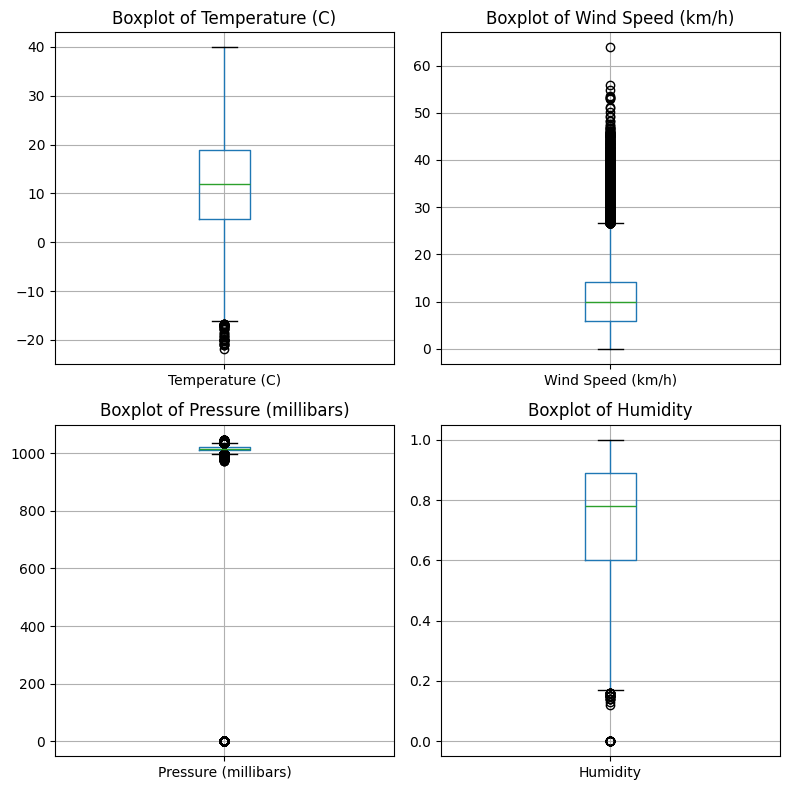

In [ ]:
fig, axes = plt.subplots(rows, cols, figsize=(8, 8))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    feature_df.boxplot(column=column, ax=axes[i])
    axes[i].set_title(f'Boxplot of {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

All four numeric variables outliers.

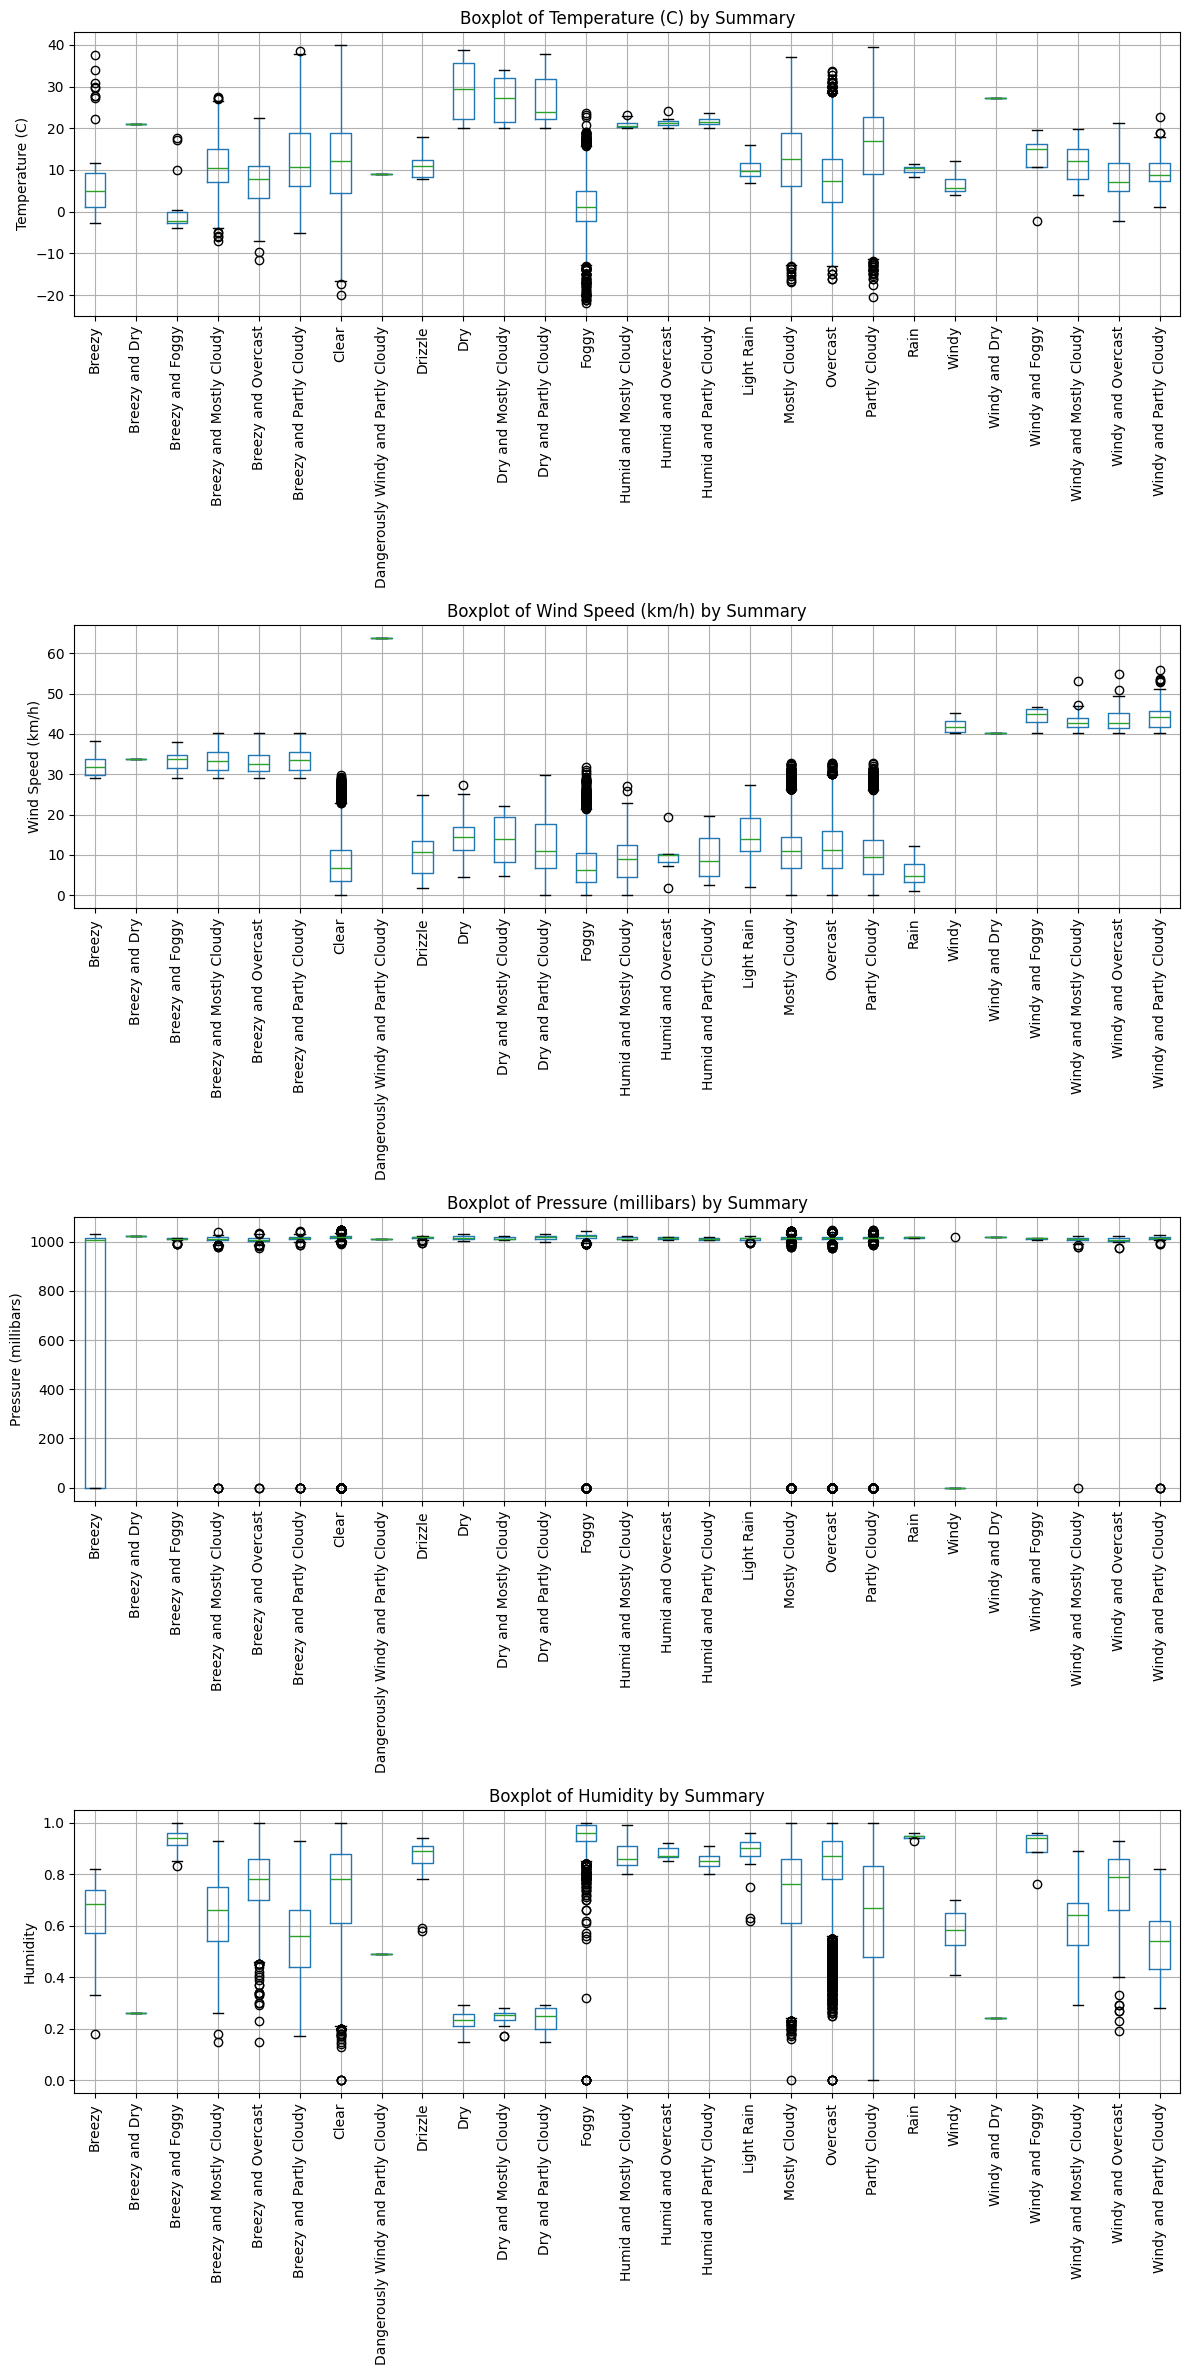

In [ ]:
rows, cols = 4, 1
fig, axes = plt.subplots(rows, cols, figsize=(12, 24))
axes = axes.flatten()

for i, column in enumerate(feature_df.columns[:rows * cols]):
    df.boxplot(column=column, by='Summary', ax=axes[i])
    axes[i].set_title(f'Boxplot of {column} by Summary')
    axes[i].set_xlabel('')
    axes[i].set_ylabel(column)
    axes[i].tick_params(axis='x', rotation=90)

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.xticks(rotation=90)
fig.suptitle('')
plt.tight_layout()
plt.show()

#### 2.2.3 Check for duplicates

In [ ]:
df.duplicated().sum()

np.int64(24)

There are 24 duplicate rows.

### 2.3 Exploratory data analysis

#### 2.3.1 Check distributions of numeric variables

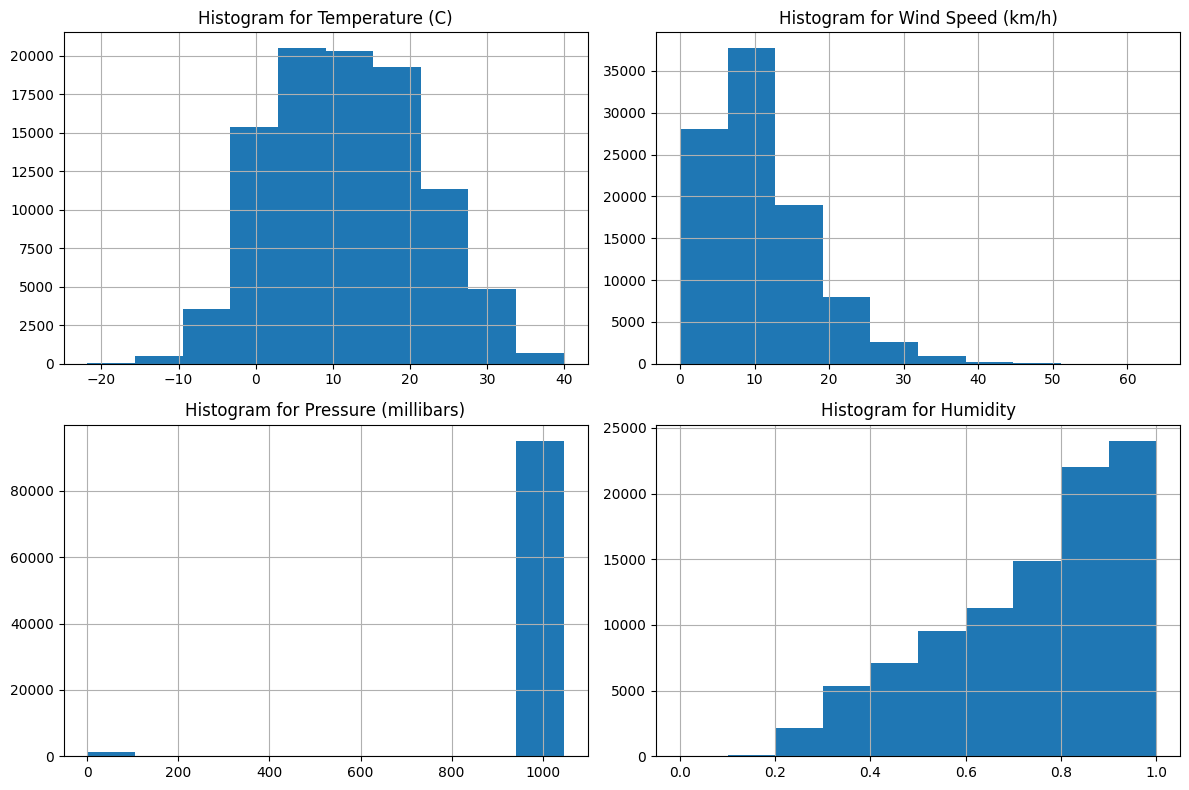

In [ ]:
rows, cols = 2, 2
fig, axes = plt.subplots(rows, cols, figsize=(12, 8))
axes = axes.flatten()

# Select only numeric columns for histogram plotting
numeric_feature_df = feature_df.select_dtypes(include=np.number)
num_numeric_columns = len(numeric_feature_df.columns)
num_plots = min(rows * cols, num_numeric_columns)


for i, column in enumerate(numeric_feature_df.columns[:rows * cols]):
    numeric_feature_df.hist(column=column, ax=axes[i])
    axes[i].set_title(f'Histogram for {column}')

for j in range(num_plots, rows * cols):
    fig.delaxes(axes[j])

plt.tight_layout()
plt.show()

#### 2.3.2 Check density of numeric variables

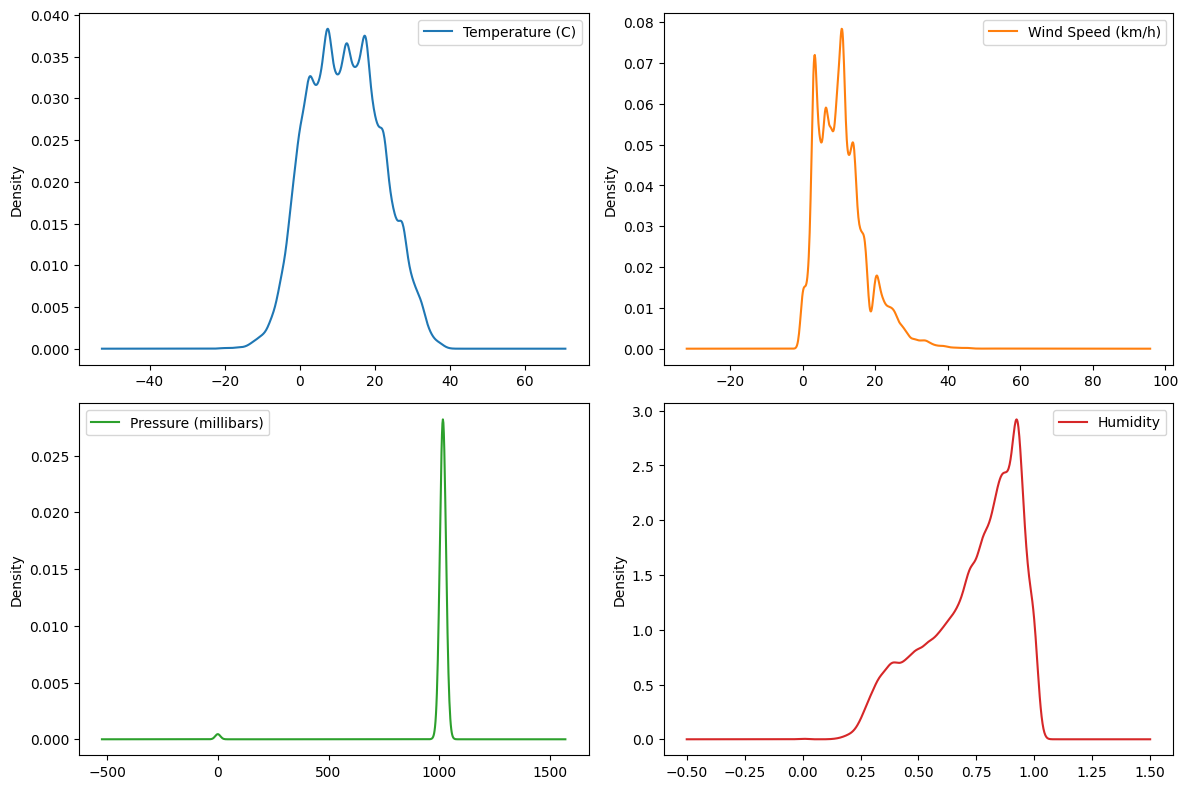

In [ ]:
feature_df.plot(kind='density', subplots=True, layout=(2, 2), figsize=(12, 8), sharex=False)
plt.tight_layout()
plt.show()

#### 2.3.3 Check skewness of continuous numeric variables

In [ ]:
numeric_feature_df.skew().to_frame().rename(columns={0:"Feature Skewness"})

,Feature Skewness
Temperature (C),0.094127
Wind Speed (km/h),1.113493
Pressure (millibars),-8.422506
Humidity,-0.715880


Temperature is not skewed.

#### 2.3.3 Check corrleations of numeric variables

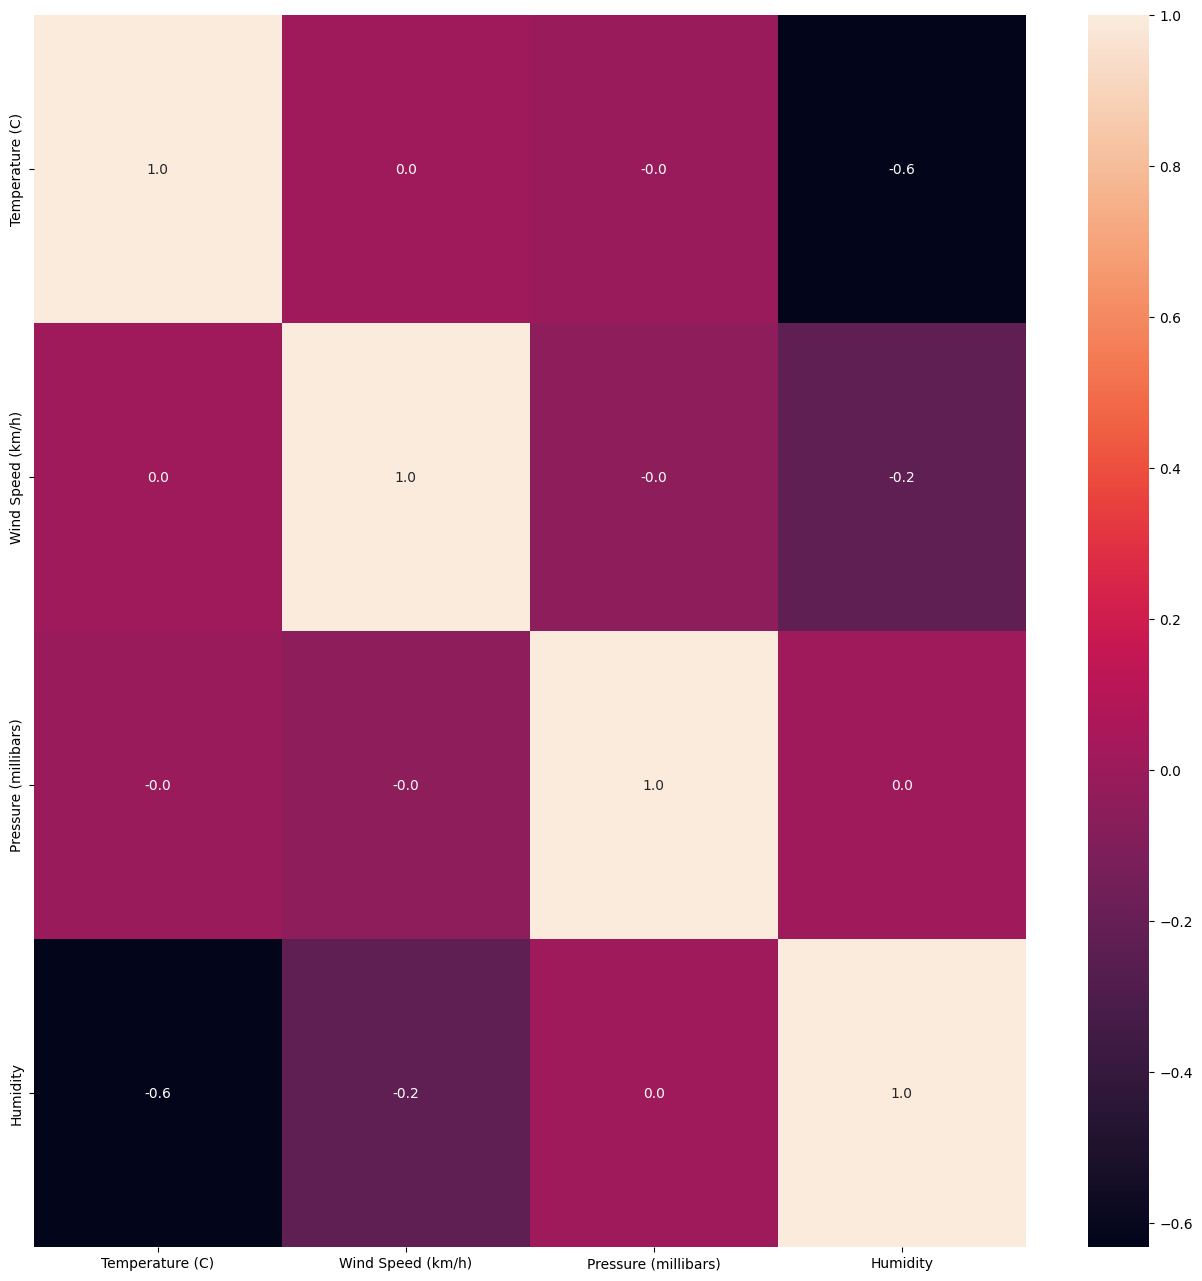

In [ ]:
plt.figure(figsize=[16,16],facecolor='white')
sns.heatmap(feature_df.corr(), annot=True, fmt=".1f")
plt.show()

No numeric features are correlated.

#### 2.3.4 Number of days by weather category for categorical features

In [ ]:
def weather_day_sum(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='Summary', data=df)
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Days by Summary Weather Type')
  plt.xticks(rotation=90)
  plt.show()

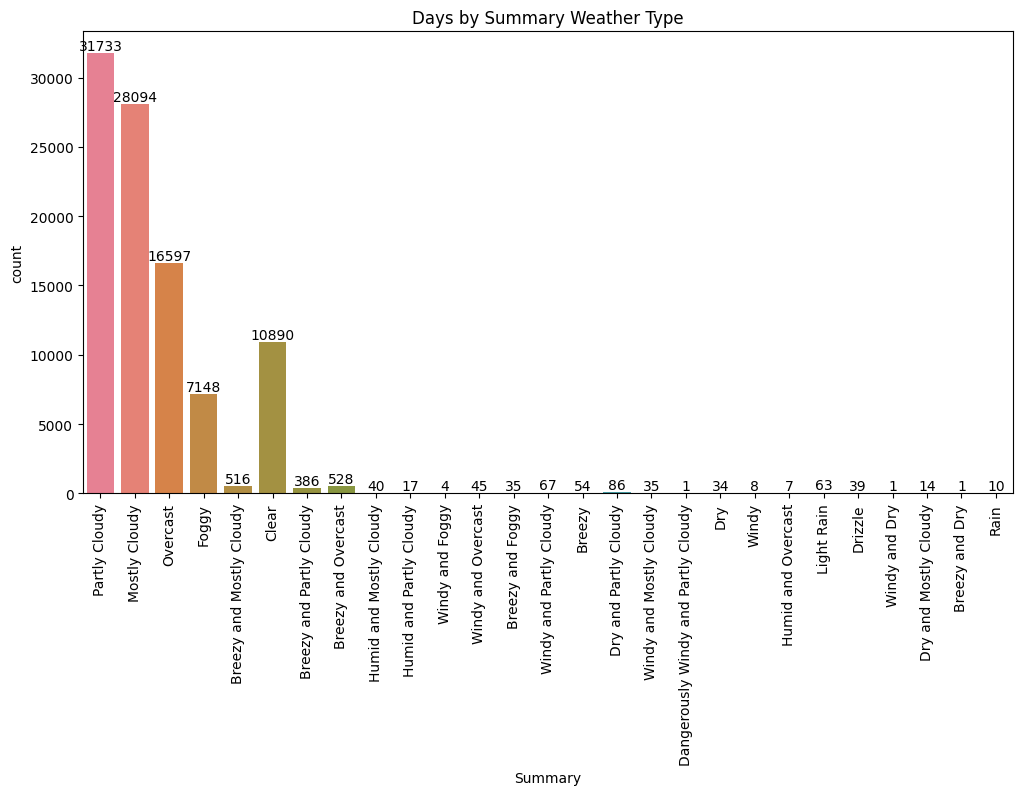

In [ ]:
weather_day_sum('Summary')

In [ ]:
def rainy_day_sum(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='Summary', data=df)
  ax.legend_.remove()
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Rainy Days by Summary Weather Type')
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
rain_df = df[df['Precip Type'] == 'rain']

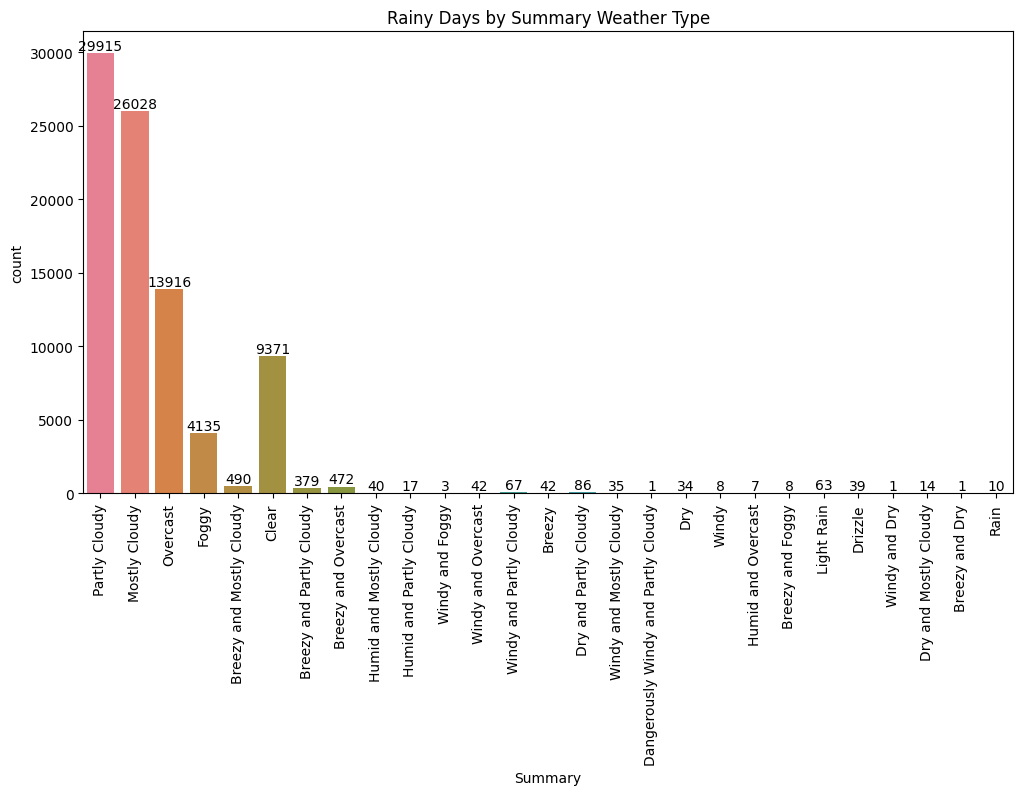

In [ ]:
rainy_day_sum(rain_df['Summary'])

In [ ]:
def snowy_day_sum(column):
  plt.figure(figsize=(12,6))
  ax = sns.countplot(x=column, hue='Summary', data=df)
  ax.legend_.remove()
  for val in ax.containers:
    ax.bar_label(val)
  plt.title(f'Snowy Days by Summary Weather Type')
  plt.xticks(rotation=90)
  plt.show()

In [ ]:
snow_df = df[df['Precip Type'] == 'snow']

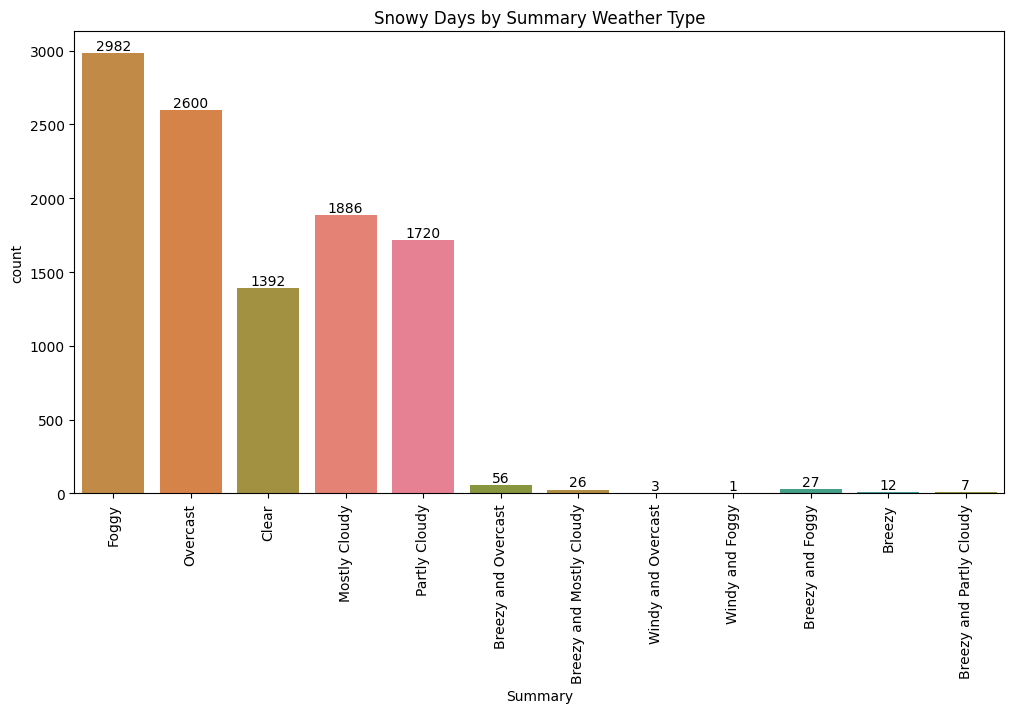

In [ ]:
snowy_day_sum(snow_df['Summary'])

## 3.0 Data preprocessing

### 3.1 Data cleansing

#### 3.1.1 No missing values

#### 3.1.2 Drop duplicate rows

In [ ]:
df = df.drop_duplicates()
df.shape

(96429, 7)

#### 3.1.3 No highly correlated features

### 3.2 Feature engineering

#### 3.2.1 Feature encoding

#### 3.2.2 Create datetime index

In [ ]:
df['Formatted Date'] = pd.to_datetime(df['Formatted Date'], format='ISO8601')
df = df.sort_values('Formatted Date').reset_index(drop=True)

In [ ]:
df.set_index('Formatted Date', inplace=True)

In [ ]:
df[:26]

,Summary,Precip Type,Temperature (C),Wind Speed (km/h),Pressure (millibars),Humidity
Formatted Date,,,,,,
2006-01-01 00:00:00+01:00,Partly Cloudy,rain,0.577778,17.1143,1016.66,0.89
2006-01-01 01:00:00+01:00,Mostly Cloudy,rain,1.161111,16.6152,1016.15,0.85
2006-01-01 02:00:00+01:00,Mostly Cloudy,rain,1.666667,20.2538,1015.87,0.82
2006-01-01 03:00:00+01:00,Overcast,rain,1.711111,14.4900,1015.56,0.82
2006-01-01 04:00:00+01:00,Mostly Cloudy,rain,1.183333,13.9426,1014.98,0.86
2006-01-01 05:00:00+01:00,Mostly Cloudy,rain,1.205556,15.9068,1014.08,0.85
2006-01-01 06:00:00+01:00,Mostly Cloudy,rain,2.222222,20.5597,1013.93,0.79
2006-01-01 07:00:00+01:00,Mostly Cloudy,rain,2.072222,25.4219,1013.24,0.81
2006-01-01 08:00:00+01:00,Mostly Cloudy,rain,2.200000,23.1679,1013.19,0.80


#### 3.3.2 Plot temperature

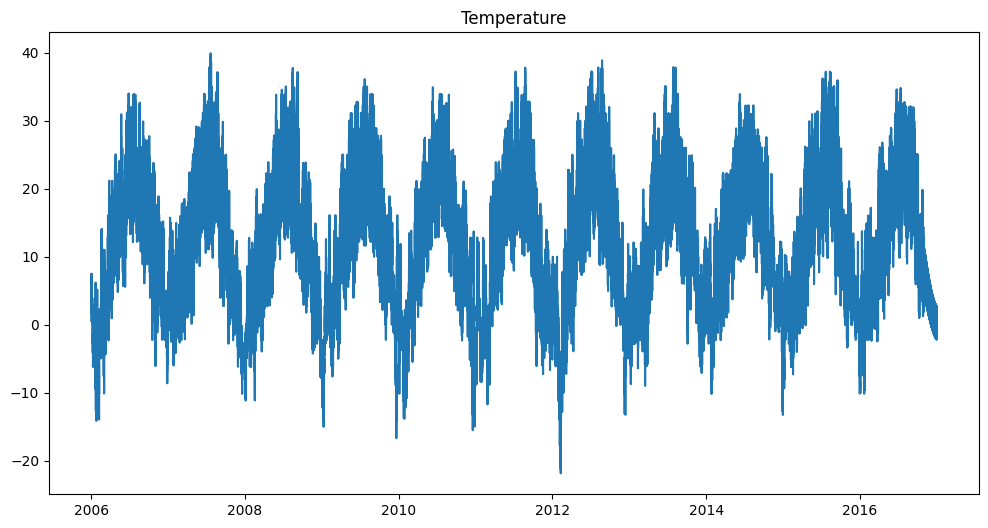

In [ ]:
temp = df['Temperature (C)']
plt.figure(figsize=(12,6))
plt.plot(temp)
plt.title('Temperature')
plt.show()

### 3.3 Data partitioning

In [ ]:
def df_to_arrays(df, window_size):
  df_as_np = df.to_numpy()
  X = []
  y = []
  for i in range(len(df_as_np)-window_size):
    row = [[a] for a in df_as_np[i:i+window_size]]
    X.append(row)
    label = df_as_np[i+window_size]
    y.append(label)
  return np.array(X), np.array(y)

In [ ]:
window_size = 6


In [ ]:
X, y = df_to_arrays(temp, window_size)

In [ ]:
X.shape, y.shape

((96423, 6, 1), (96423,))

In [ ]:
X_train, y_train = X[:85000], y[:85000]
X_val, y_val = X[85000:90000], y[85000:90000]
X_test, y_test = X[90000:], y[90000:]

In [ ]:
X_train.shape, y_train.shape, X_val.shape, y_val.shape, X_test.shape, y_test.shape

((85000, 6, 1), (85000,), (5000, 6, 1), (5000,), (6423, 6, 1), (6423,))

### 3.4 Data transformation

#### 3.4.1 Resphape data for multi-layer perceptron regressor

In [ ]:
X_train_mlp = X_train.reshape(X_train.shape[0], -1)
X_val_mlp = X_val.reshape(X_val.shape[0], -1)
X_test_mlp = X_test.reshape(X_test.shape[0], -1)

In [ ]:
X_train_mlp.shape, X_val_mlp.shape, X_test_mlp.shape

((85000, 6), (5000, 6), (6423, 6))

#### 3.4.2 Scale numeric variables

In [ ]:
scaler = StandardScaler()

In [ ]:
X_train_mlp = scaler.fit_transform(X_train_mlp)
X_val_mlp = scaler.transform(X_val_mlp)
X_test_mlp = scaler.transform(X_test_mlp)

#### 3.4.3 MLPRegressor hyperparameter selection

In [ ]:
def evaluate_mlp_grid(X_train_mlp, y_train, X_val_mlp, y_val):
    results = []

    layer_sizes = [20, 60, 100]
    activations = ['relu', 'logistic', 'tanh']  # logistic = sigmoid
    solvers = ['adam', 'lbfgs', 'sgd']
    max_iters = [20, 60, 100]
    learning_rates = [0.01, 0.005, 0.001]

    config_grid = list(product(layer_sizes, activations, solvers, max_iters, learning_rates))

    for i, (size, act, solver, max_iter, lr) in enumerate(config_grid):
        hidden = (size, size)
        model = MLPRegressor(hidden_layer_sizes=hidden,
                             activation=act,
                             solver=solver,
                             max_iter=max_iter,
                             learning_rate_init=lr,
                             random_state=42)


        model.fit(X_train_mlp, y_train)

        y_train_pred = model.predict(X_train_mlp)
        y_val_pred = model.predict(X_val_mlp)

        train_loss = model.loss_

        train_mse = mean_squared_error(y_train, y_train_pred)
        val_mse = mean_squared_error(y_val, y_val_pred)

        train_rmse = np.sqrt(train_mse)
        val_rmse = np.sqrt(val_mse)

        results.append({
            'hidden_layer_size': hidden,
            'activation': act,
            'solver': solver,
            'max_iter': max_iter,
            'learning_rate_init': lr,
            'train_mse': train_mse,
            'val_mse': val_mse,
            #'test_mse': test_mse,
            'train_rmse': train_rmse,
            'val_rmse': val_rmse,
            #'test_rmse': test_rmse,
            'final_loss': train_loss if hasattr(model, "loss_") else None
        })

        loss_display = f"{train_loss:.4f}" if hasattr(model, "loss_") else "N/A"

        print(f"Run {i+1}/{len(config_grid)}: {hidden}, {act}, {solver}, {max_iter}, {lr} | "
          f"Val MSE: {val_mse:.4f}, Val RMSE: {val_rmse:.4f}, Final Loss: {loss_display}")

    df_results = pd.DataFrame(results)

    best = df_results.loc[df_results['val_mse'].idxmin()]
    print("\n🏆 Best Model Configuration:")
    print(best)

    return df_results

In [ ]:
mlp_results = evaluate_mlp_grid(X_train_mlp, y_train, X_val_mlp, y_val)

Run 1/243: (20, 20), relu, adam, 20, 0.01 | Val MSE: 0.7935, Val RMSE: 0.8908, Final Loss: 0.7305
Run 2/243: (20, 20), relu, adam, 20, 0.005 | Val MSE: 0.8114, Val RMSE: 0.9008, Final Loss: 0.7197
Run 3/243: (20, 20), relu, adam, 20, 0.001 | Val MSE: 0.8095, Val RMSE: 0.8997, Final Loss: 0.7348
Run 4/243: (20, 20), relu, adam, 60, 0.01 | Val MSE: 0.7923, Val RMSE: 0.8901, Final Loss: 0.6812
Run 5/243: (20, 20), relu, adam, 60, 0.005 | Val MSE: 0.8245, Val RMSE: 0.9080, Final Loss: 0.6837
Run 6/243: (20, 20), relu, adam, 60, 0.001 | Val MSE: 0.8315, Val RMSE: 0.9119, Final Loss: 0.7128
Run 7/243: (20, 20), relu, adam, 100, 0.01 | Val MSE: 0.8264, Val RMSE: 0.9091, Final Loss: 0.6694
Run 8/243: (20, 20), relu, adam, 100, 0.005 | Val MSE: 0.7884, Val RMSE: 0.8879, Final Loss: 0.6760
Run 9/243: (20, 20), relu, adam, 100, 0.001 | Val MSE: 0.8019, Val RMSE: 0.8955, Final Loss: 0.7011
Run 10/243: (20, 20), relu, lbfgs, 20, 0.01 | Val MSE: 0.9061, Val RMSE: 0.9519, Final Loss: 0.8250
Run 11/24

## 4.0 Modeling

### 4.1. MLPRegressor model

In [ ]:
model2 = MLPRegressor(max_iter=100, hidden_layer_sizes=(100, 100), learning_rate_init=0.005, solver='adam', activation='relu')

### 4.2 MLPRegressor fit including back propagation

In [ ]:
model2.fit(X_train_mlp, y_train)

MLPRegressor(hidden_layer_sizes=(100, 100), learning_rate_init=0.005,
             max_iter=100)

### 4.3 MLPRegressor training predictions

In [ ]:
train2_predictions = model2.predict(X_train_mlp)
train2_results = pd.DataFrame(data={'Train Predictions':train2_predictions, 'Actuals':y_train})
train2_results

,Train Predictions,Actuals
0,0.735593,2.222222
1,2.280069,2.072222
2,1.878144,2.200000
3,2.047305,2.733333
4,2.618838,2.788889
...,...,...
84995,14.661626,12.777778
84996,12.485180,12.777778
84997,12.066330,11.972222
84998,11.313549,11.061111


### 4.4 MLP training performance

In [ ]:
train2_mse = mean_squared_error(y_train, train2_predictions)
train2_rmse = train2_mse ** 0.5

print(f"Training MSE: {train2_mse:.4f}")
print(f"Training RMSE: {train2_rmse:.4f}")

Training MSE: 1.3147
Training RMSE: 1.1466


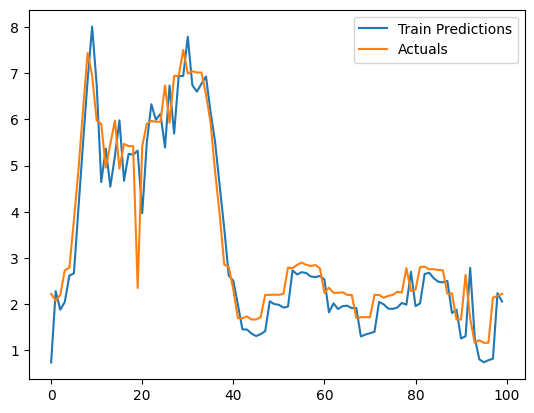

In [ ]:
plt.plot(train2_results['Train Predictions'][:100])
plt.plot(train2_results['Actuals'][:100])
plt.legend(['Train Predictions', 'Actuals'])
plt.show()

### 4.5 MLPRegressor validation predictions

In [ ]:
val2_predictions = model2.predict(X_val_mlp)
val2_results = pd.DataFrame(data={'Validation Predictions':val2_predictions, 'Actuals':y_val})
val2_results

,Validation Predictions,Actuals
0,11.134579,10.444444
1,10.270570,8.888889
2,8.793946,8.888889
3,8.771845,9.238889
4,9.163203,7.777778
...,...,...
4995,15.496911,15.355556
4996,15.209193,14.977778
4997,15.090055,13.916667
4998,13.903873,14.977778


### 4.6 MLPRegressor validation performance

In [ ]:
val2_mse = mean_squared_error(y_val, val2_predictions)
val2_rmse = val2_mse ** 0.5

print(f"Validation MSE: {val2_mse:.4f}")
print(f"Validation RMSE: {val2_rmse:.4f}")

Validation MSE: 0.8555
Validation RMSE: 0.9250


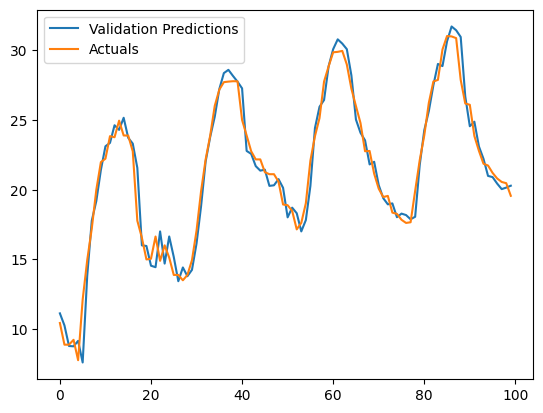

In [ ]:
plt.plot(val2_results['Validation Predictions'][:100])
plt.plot(val2_results['Actuals'][:100])
plt.legend(['Validation Predictions', 'Actuals'])
plt.show()

## 5.0 Evaluation

### 5.1 MLPRegressor test predictions

In [ ]:
test2_predictions = model2.predict(X_test_mlp).flatten()
test2_results = pd.DataFrame(data={'Test Predictions':test2_predictions, 'Actuals':y_test})
test2_results

,Test Predictions,Actuals
0,17.370380,17.133333
1,18.562968,17.855556
2,18.834448,18.800000
3,19.185456,18.800000
4,18.960421,17.344444
...,...,...
6418,0.687809,0.488889
6419,0.214852,0.072222
6420,-0.198987,-0.233333
6421,-0.548475,-0.472222


### 5.2 MLPRegressor test performance

In [ ]:
test2_mse = mean_squared_error(y_test, test2_predictions)
test2_rmse = test2_mse ** 0.5

print(f"Test MSE: {test2_mse:.4f}")
print(f"Test RMSE: {test2_rmse:.4f}")

Test MSE: 0.8616
Test RMSE: 0.9282


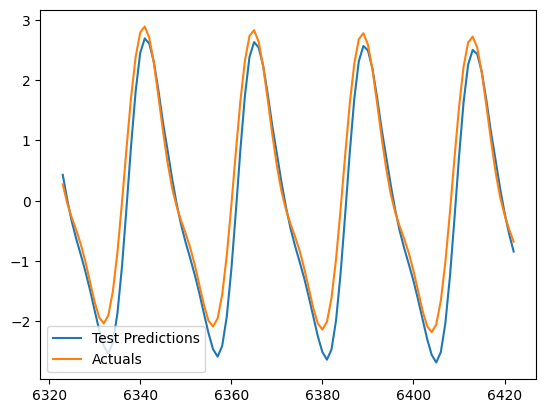

In [ ]:
plt.plot(test2_results['Test Predictions'][-100:])
plt.plot(test2_results['Actuals'][-100:])
plt.legend(['Test Predictions', 'Actuals'])
plt.show()

### 5.3 MLPRegressor learning curve

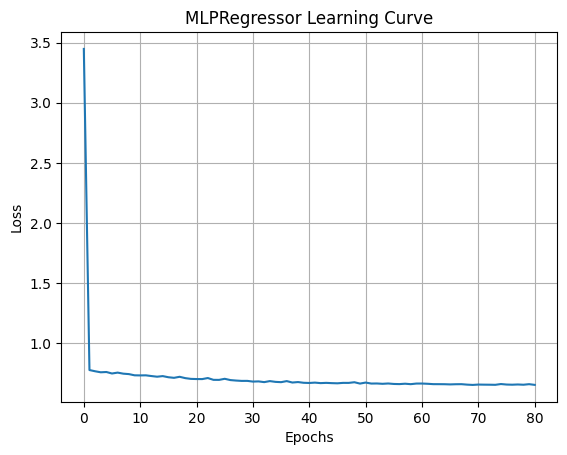

In [ ]:
plt.plot(model2.loss_curve_)
plt.title("MLPRegressor Learning Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.grid(True)
plt.show()

### 5.4 MLPRegressor architecture

In [ ]:
def plot_mlp_structure(model):
    layer_sizes = [len(model.coefs_[0]), *model.hidden_layer_sizes, 1]
    G = nx.DiGraph()

    # Add nodes layer by layer
    for i, size in enumerate(layer_sizes):
        for j in range(size):
            G.add_node(f"L{i}_{j}", layer=i)

    # Add edges
    for i in range(len(layer_sizes)-1):
        for a in range(layer_sizes[i]):
            for b in range(layer_sizes[i+1]):
                G.add_edge(f"L{i}_{a}", f"L{i+1}_{b}")

    pos = nx.multipartite_layout(G, subset_key="layer")
    nx.draw(G, pos, with_labels=False, node_size=50)
    plt.title("MLPRegressor Architecture")
    plt.show()

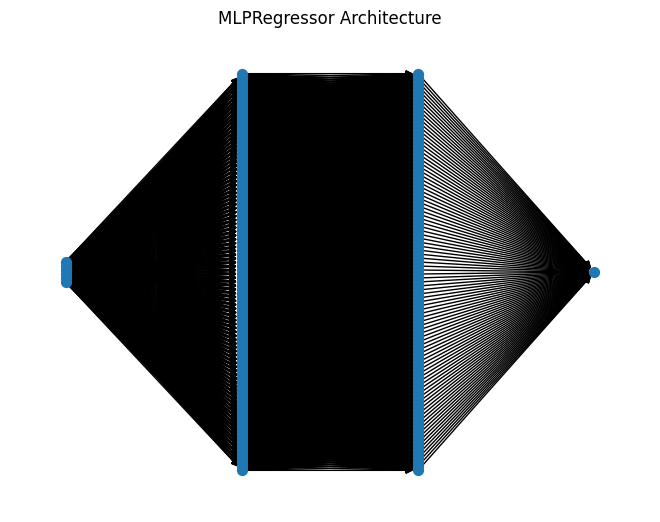

In [ ]:
plot_mlp_structure(model2)

## 6.0 Deployment

Paper: ComfortJDDS8536-6 - England Temperature Forecast Using a Multilayer Perceptron Regressor